In [ ]:
!pip install tensorflow==2.5
!pip install keras==2.6
!pip install qiskit
!pip install yfinance
!pip install matplotlib
!pip install pennylane
!pip install sklearn
!pip install qiskit-machine-learning

In [3]:
import tensorflow as tf
import qiskit as qk
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
from qiskit.opflow import AerPauliExpectation, CircuitSampler, StateFn
from qiskit_machine_learning.algorithms.distribution_learners.qgan import QGAN

In [4]:
ticker = "AAPL" 
start_date = "2015-01-01"
end_date = "2023-03-16"
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
q = qk.QuantumRegister(1)
c = qk.ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.measure(q[0], c[0])

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_81 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_82 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 513       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 512)               1024      
________________________

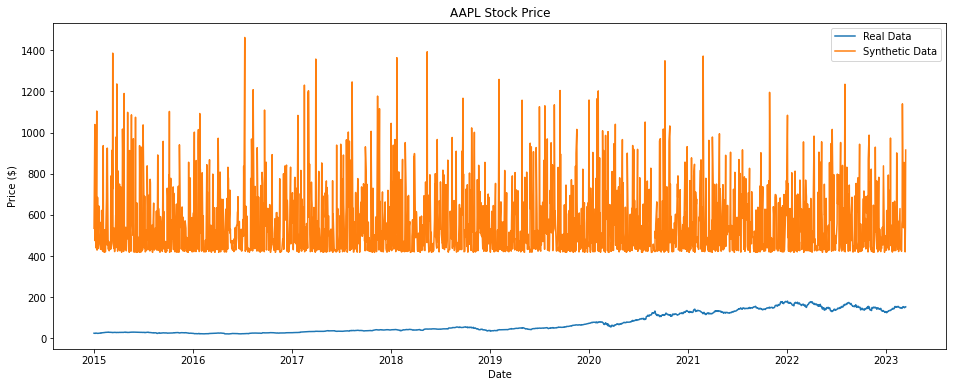

In [22]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.summary()
    noise = Input(shape=(1,))
    gen_data = model(noise)
    return tf.keras.models.Model(noise, gen_data)

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    real_data = Input(shape=(1,))
    validity = model(real_data)
    return tf.keras.models.Model(real_data, validity)

# Define QGAN model
def build_qgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(learning_rate=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

generator = build_generator()
discriminator = build_discriminator()
qgan = build_qgan(generator, discriminator)

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train QGAN
num_epochs = 2000
batch_size = 64

for epoch in range(num_epochs):
    noise = np.random.normal(0, 1, (batch_size, 1))
    gen_data = generator.predict(noise)
    real_data = stock_data["Adj Close"].values.reshape((-1, 1))[np.random.randint(0, len(stock_data), batch_size)]
    X = np.concatenate((real_data, gen_data))
    y = np.zeros((2*batch_size, 1))
    y[:batch_size, :] = 1
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)
    noise = np.random.normal(0, 1, (batch_size, 1))
    y = np.ones((batch_size, 1))
    discriminator.trainable = False
    g_loss = qgan.train_on_batch(noise, y)
    if epoch % 1000 == 0:
        print("Epoch", epoch, "D loss:", d_loss, "G loss:", g_loss)

# Generate synthetic data
num_samples = len(stock_data)
noise = np.random.normal(0, 1, (num_samples, 1))
gen_data = generator.predict(noise)
gen_data = np.squeeze(gen_data)

# Plot real and synthetic data
plt.figure(figsize=(16, 6))
plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
plt.plot(stock_data.index, gen_data, label="Synthetic Data")
plt.legend()
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_65 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_66 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 513       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 512)               1024      
________________________

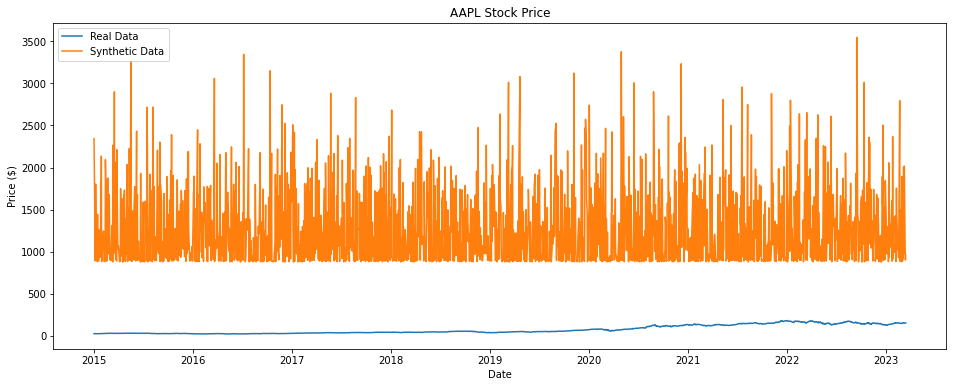

In [20]:
# Define QGAN model with Wasserstein loss
def build_qgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=optimizer)
    return model

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

generator = build_generator()
discriminator = build_discriminator()
qgan = build_qgan(generator, discriminator)

discriminator.compile(optimizer=RMSprop(learning_rate=0.00005), loss=wasserstein_loss)

# Train QGAN
num_epochs = 2000
batch_size = 64

for epoch in range(num_epochs):
    noise = np.random.normal(0, 1, (batch_size, 1))
    gen_data = generator.predict(noise)
    real_data = stock_data["Adj Close"].values.reshape((-1, 1))[np.random.randint(0, len(stock_data), batch_size)]
    X = np.concatenate((real_data, gen_data))
    y = np.ones((2*batch_size, 1))
    y[:batch_size, :] = -1
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)
    noise = np.random.normal(0, 1, (batch_size, 1))
    y = np.ones((batch_size, 1))
    discriminator.trainable = False
    g_loss = qgan.train_on_batch(noise, y)
    if epoch % 1000 == 0:
        print("Epoch", epoch, "D loss:", d_loss, "G loss:", g_loss)

# Generate synthetic data
num_samples = len(stock_data)
noise = np.random.normal(0, 1, (num_samples, 1))
gen_data = generator.predict(noise)
gen_data = np.squeeze(gen_data)

# Plot real and synthetic data
plt.figure(figsize=(16, 6))
plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
plt.plot(stock_data.index, gen_data, label="Synthetic Data")
plt.legend()
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 513       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               1024      
________________________

Epoch 0 D loss: 1.8169100284576416 G loss: 0.6935712695121765


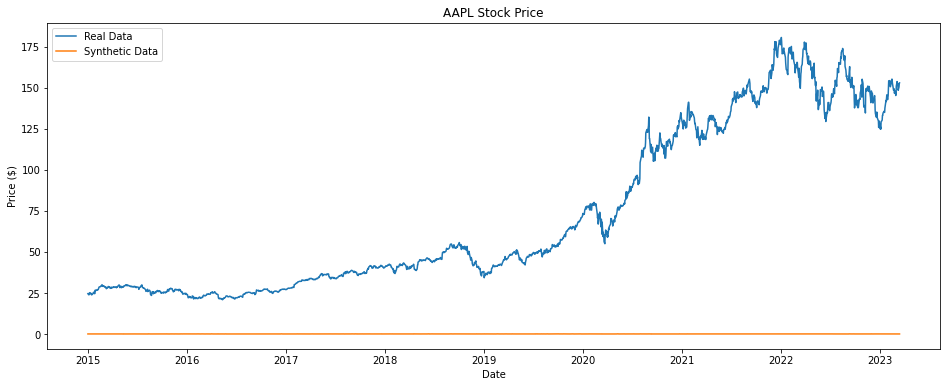

Epoch 1000 D loss: 1.4999465942382812 G loss: 0.6931588649749756


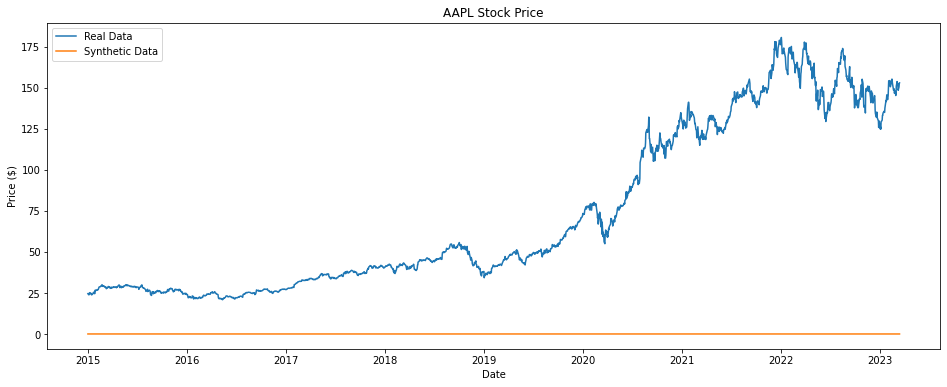

Epoch 2000 D loss: 1.7240262031555176 G loss: 0.6931638717651367


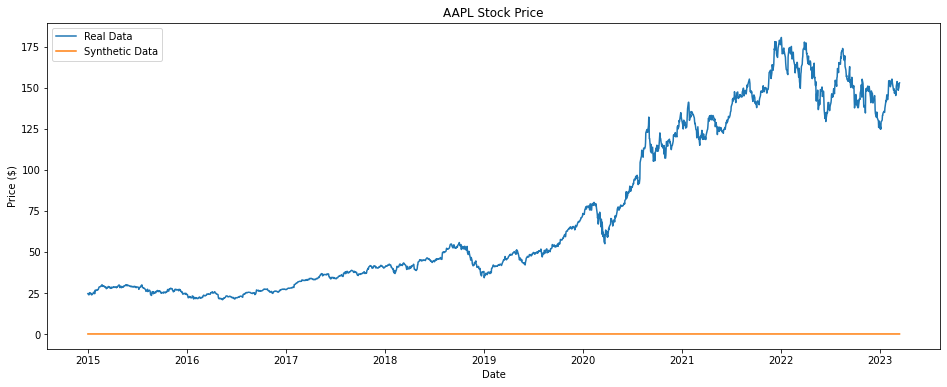

Epoch 3000 D loss: 1.6068382263183594 G loss: 0.693151593208313


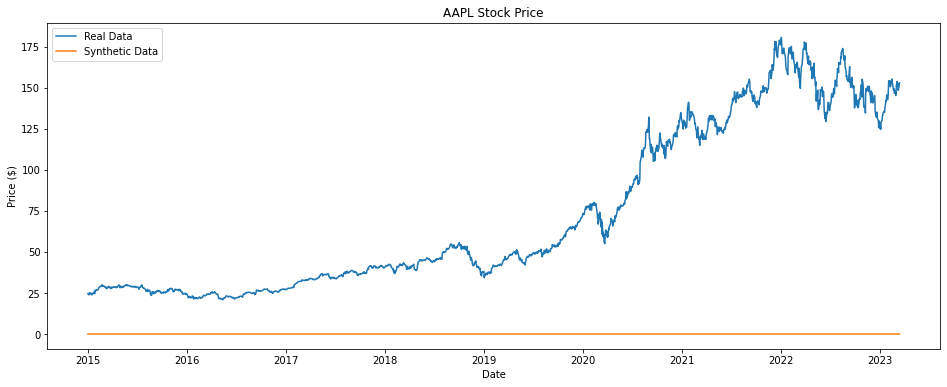

Epoch 4000 D loss: 1.8465979099273682 G loss: 0.6931495666503906


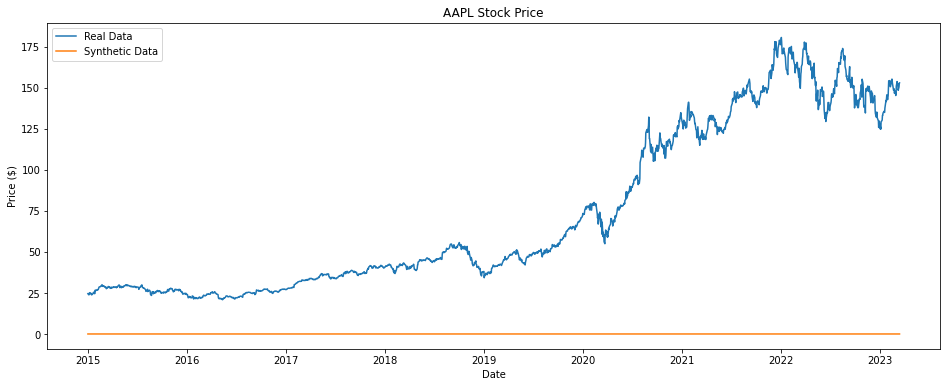

Epoch 5000 D loss: 1.6854205131530762 G loss: 0.6931480169296265


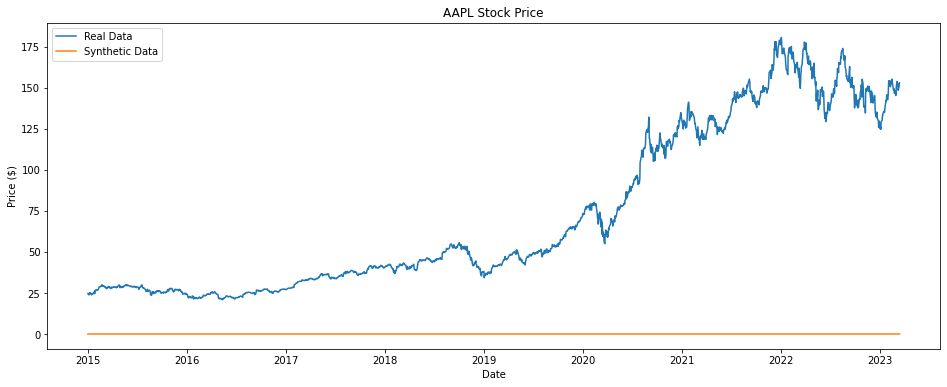

Epoch 6000 D loss: 1.5954498052597046 G loss: 0.6931498646736145


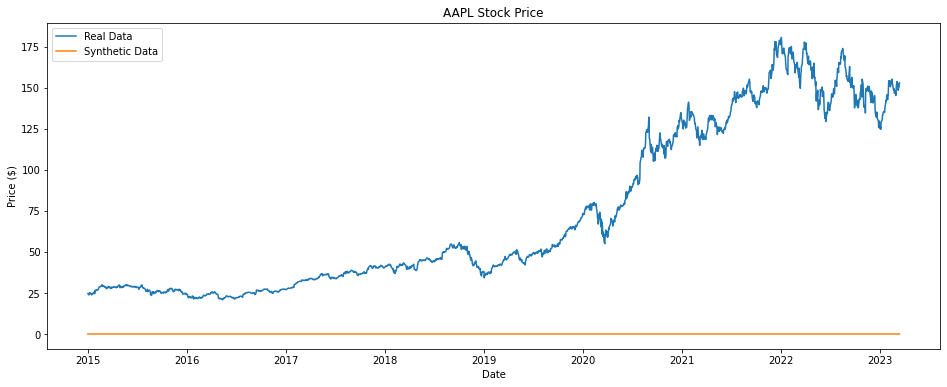

Epoch 7000 D loss: 1.740809679031372 G loss: 0.6931486129760742


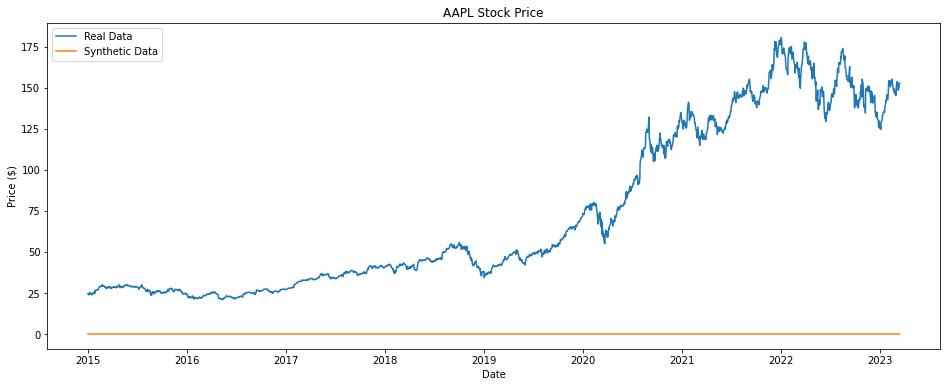

Epoch 8000 D loss: 1.8423478603363037 G loss: 0.6931472420692444


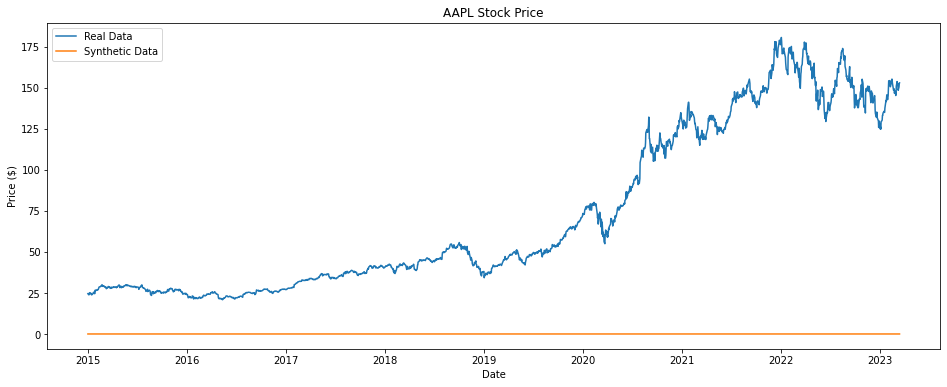

Epoch 9000 D loss: 1.794287919998169 G loss: 0.693148136138916


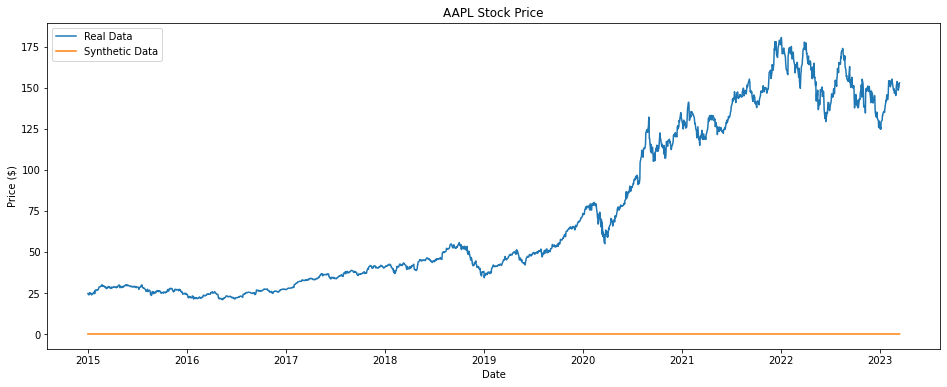

Epoch 10000 D loss: 1.7590954303741455 G loss: 0.6931482553482056


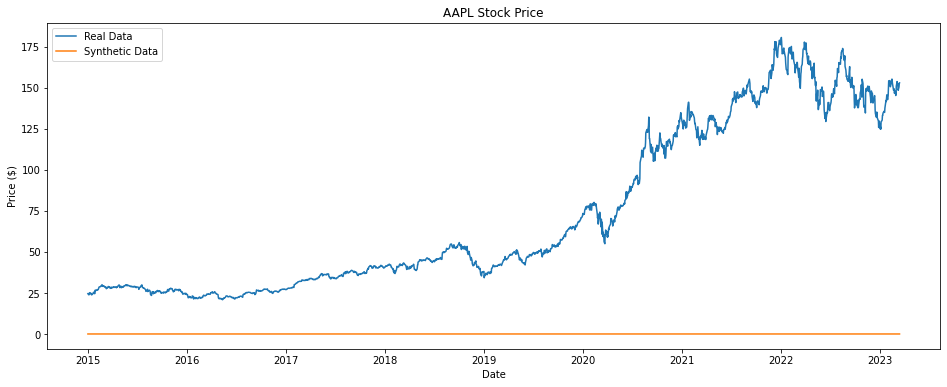

Epoch 11000 D loss: 1.7511643171310425 G loss: 0.6931473016738892


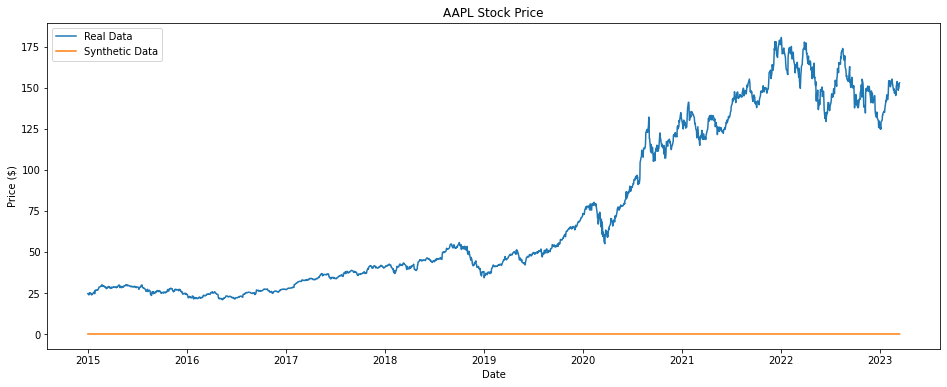

Epoch 12000 D loss: 1.6837759017944336 G loss: 0.6931475400924683


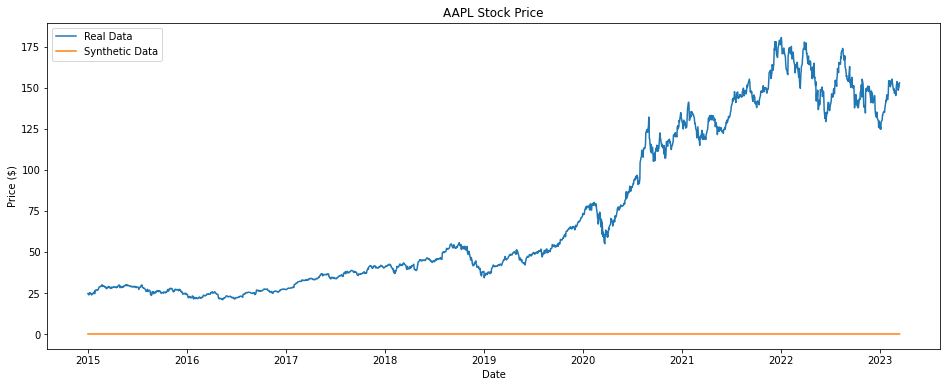

Epoch 13000 D loss: 1.7719438076019287 G loss: 0.6931474208831787


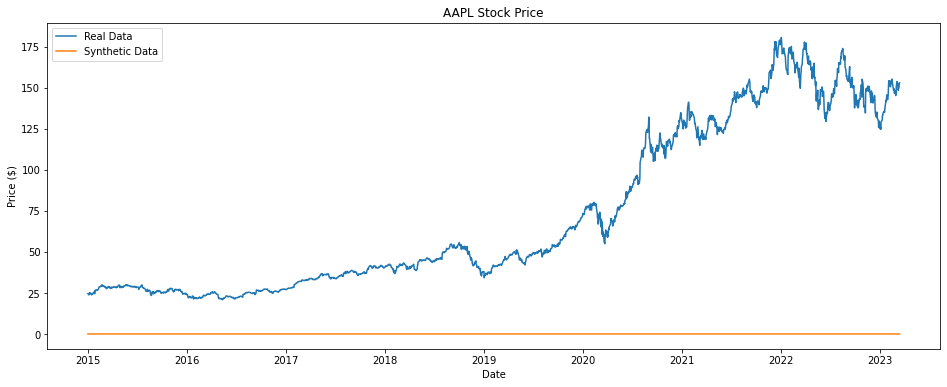

Epoch 14000 D loss: 1.530959129333496 G loss: 0.693148136138916


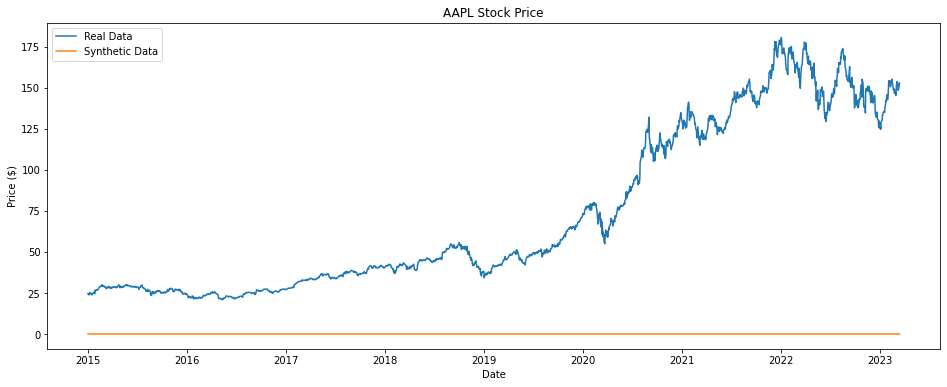

Epoch 15000 D loss: 1.55263090133667 G loss: 0.6931475400924683


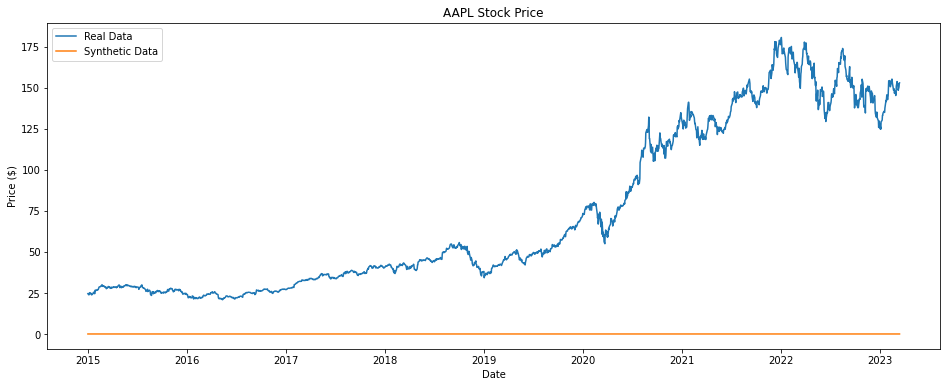

Epoch 16000 D loss: 1.6331182718276978 G loss: 0.6931493282318115


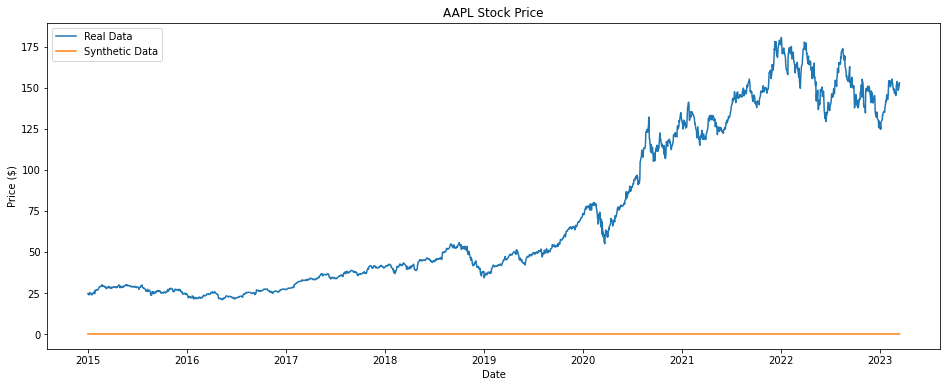

Epoch 17000 D loss: 1.8807718753814697 G loss: 0.6931480765342712


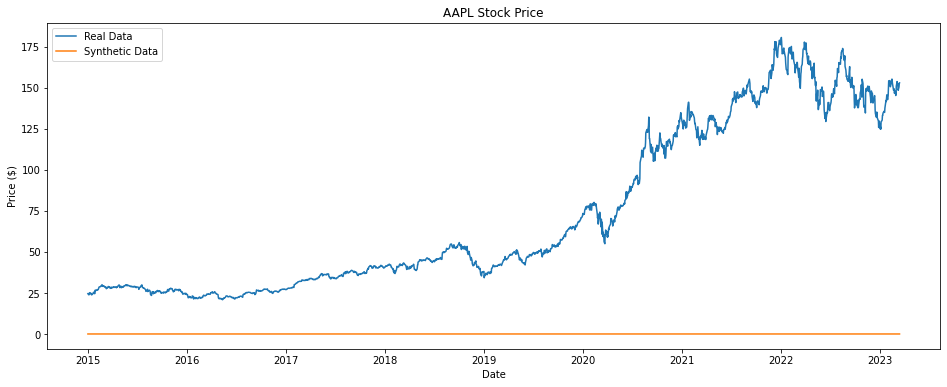

Epoch 18000 D loss: 1.954707384109497 G loss: 0.6931479573249817


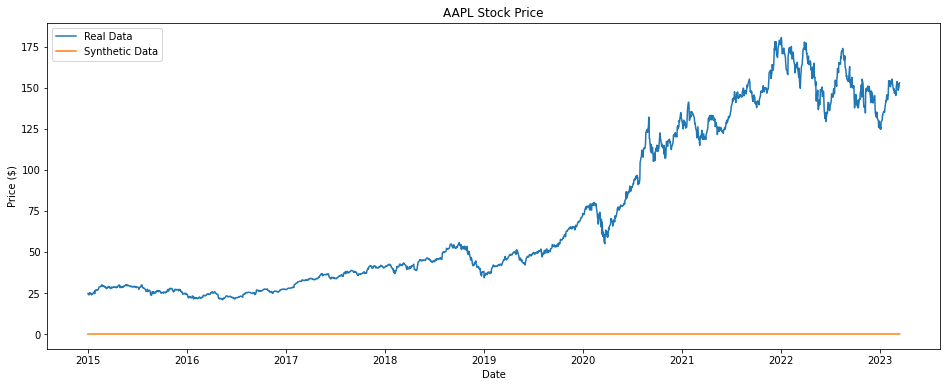

Epoch 19000 D loss: 1.8551030158996582 G loss: 0.693148136138916


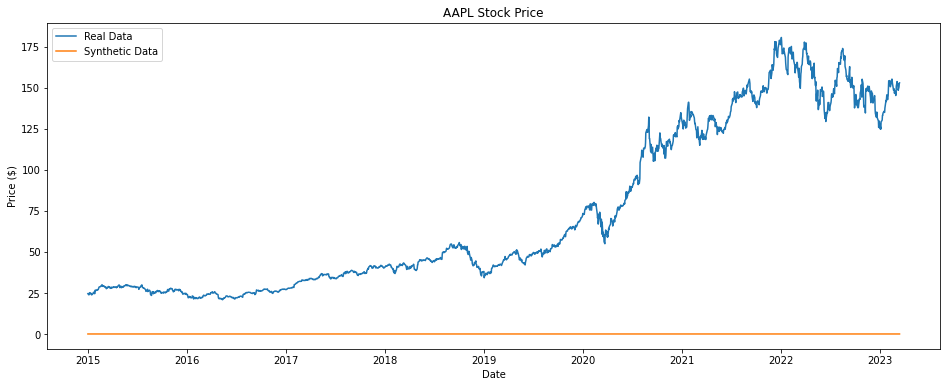

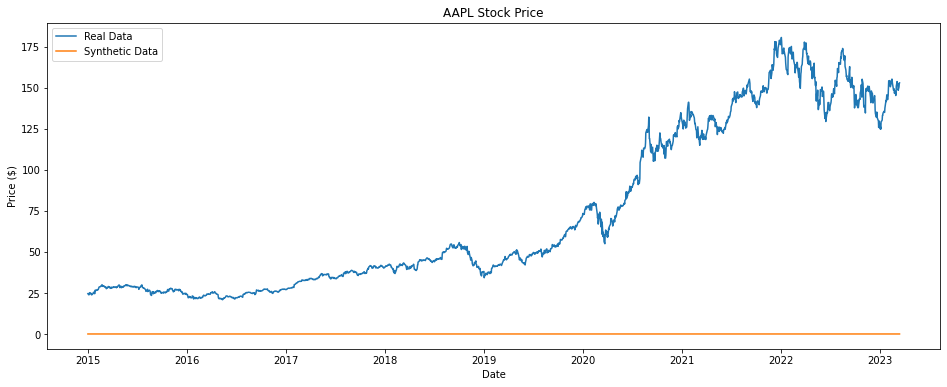

In [12]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.summary()
    noise = Input(shape=(1,))
    gen_data = model(noise)
    return tf.keras.models.Model(noise, gen_data)

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    real_data = Input(shape=(1,))
    validity = model(real_data)
    return tf.keras.models.Model(real_data, validity)

def build_qgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

generator = build_generator()
discriminator = build_discriminator()
qgan = build_qgan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')

num_epochs = 20000
batch_size = 32

for epoch in range(num_epochs):
    noise = np.random.normal(0, 1, (batch_size, 1))
    gen_data = generator.predict(noise)
    real_data = stock_data["Adj Close"].values.reshape((-1, 1))[np.random.randint(0, len(stock_data), batch_size)]
    X = np.concatenate((real_data, gen_data))
    y = np.zeros((2*batch_size, 1))
    y[:batch_size, :] = 1
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)
    noise = np.random.normal(0, 1, (batch_size, 1))
    y = np.ones((batch_size, 1))
    discriminator.trainable = False
    g_loss = qgan.train_on_batch(noise, y)
    if epoch % 1000 == 0:
        print("Epoch", epoch, "D loss:", d_loss, "G loss:", g_loss)
        
        num_samples = len(stock_data)
        noise = np.random.normal(0, 1, (num_samples, 1))
        gen_data = generator.predict(noise)
        gen_data = np.squeeze(gen_data)

        plt.figure(figsize=(16, 6))
        plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
        plt.plot(stock_data.index, gen_data, label="Synthetic Data")
        plt.legend()
        plt.title(f"{ticker} Stock Price")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.show()

num_samples = len(stock_data)
noise = np.random.normal(0, 1, (num_samples, 1))
gen_data = generator.predict(noise)
gen_data = np.squeeze(gen_data)

plt.figure(figsize=(16, 6))
plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
plt.plot(stock_data.index, gen_data, label="Synthetic Data")
plt.legend()
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               1024      
__________________________

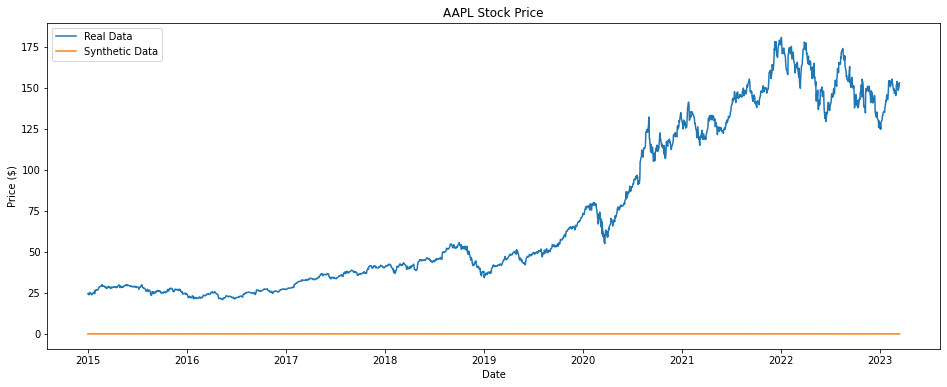

Epoch 1000 D loss: 5.953854560852051 G loss: 0.00036733876913785934


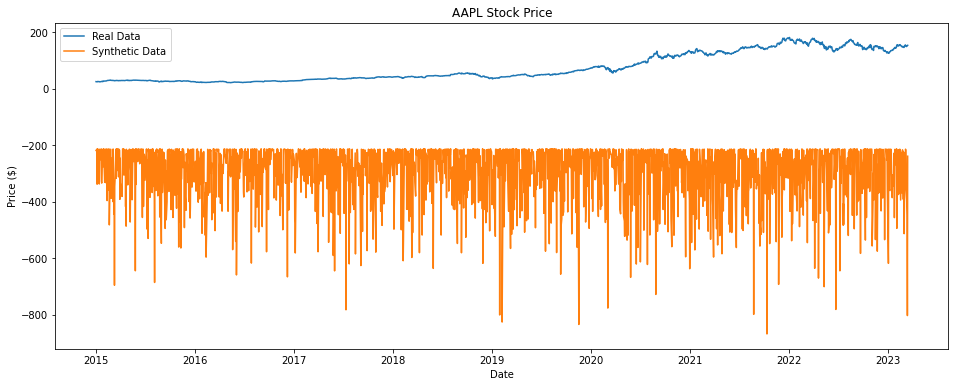

Epoch 2000 D loss: 7.4513750076293945 G loss: 5.108352706884034e-05


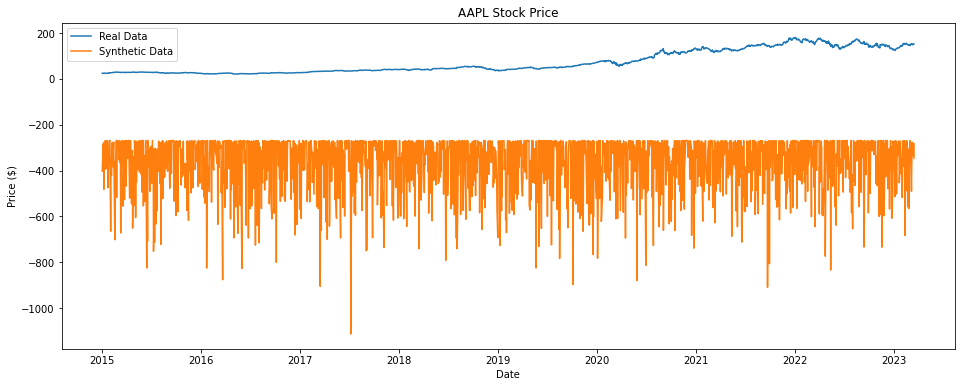

Epoch 3000 D loss: 8.150215148925781 G loss: 1.917425288411323e-05


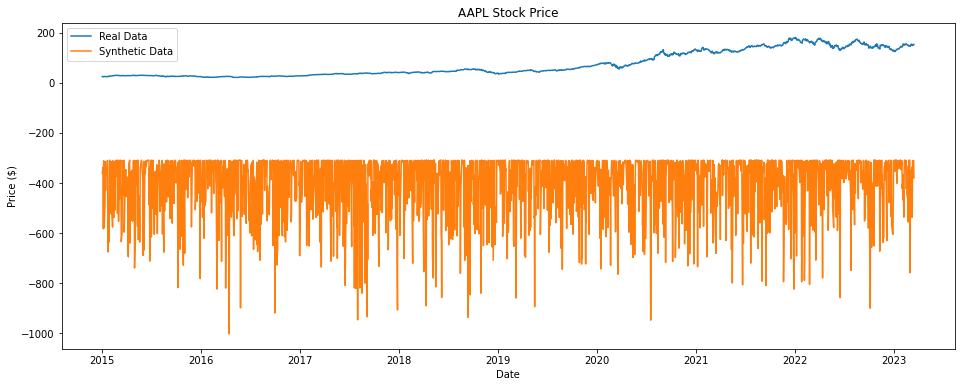

Epoch 4000 D loss: 8.761691093444824 G loss: 4.911618361802539e-06


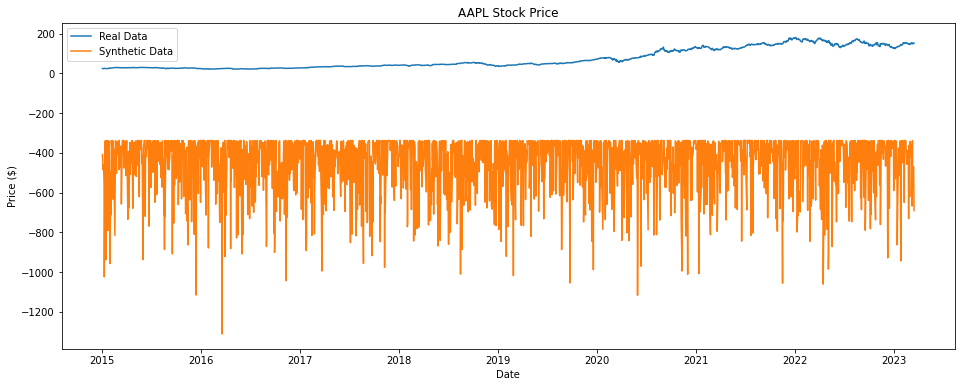

KeyboardInterrupt: ignored

In [6]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.summary()
    noise = Input(shape=(1,))
    gen_data = model(noise)
    return tf.keras.models.Model(noise, gen_data)

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    real_data = Input(shape=(1,))
    validity = model(real_data)
    return tf.keras.models.Model(real_data, validity)

def build_qgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

generator = build_generator()
discriminator = build_discriminator()
qgan = build_qgan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')

num_epochs = 20000
batch_size = 32

for epoch in range(num_epochs):
    noise = np.random.normal(0, 1, (batch_size, 1))
    gen_data = generator.predict(noise)
    real_data = stock_data["Adj Close"].values.reshape((-1, 1))[np.random.randint(0, len(stock_data), batch_size)]
    X = np.concatenate((real_data, gen_data))
    y = np.zeros((2*batch_size, 1))
    y[:batch_size, :] = 1
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)
    noise = np.random.normal(0, 1, (batch_size, 1))
    y = np.ones((batch_size, 1))
    discriminator.trainable = False
    g_loss = qgan.train_on_batch(noise, y)
    if epoch % 1000 == 0:
        print("Epoch", epoch, "D loss:", d_loss, "G loss:", g_loss)
        
        num_samples = len(stock_data)
        noise = np.random.normal(0, 1, (num_samples, 1))
        gen_data = generator.predict(noise)
        gen_data = np.squeeze(gen_data)

        plt.figure(figsize=(16, 6))
        plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
        plt.plot(stock_data.index, gen_data, label="Synthetic Data")
        plt.legend()
        plt.title(f"{ticker} Stock Price")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.show()

num_samples = len(stock_data)
noise = np.random.normal(0, 1, (num_samples, 1))
gen_data = generator.predict(noise)
gen_data = np.squeeze(gen_data)

plt.figure(figsize=(16, 6))
plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
plt.plot(stock_data.index, gen_data, label="Synthetic Data")
plt.legend()
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_28 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_29 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_30 (Dense)             (None, 1)                

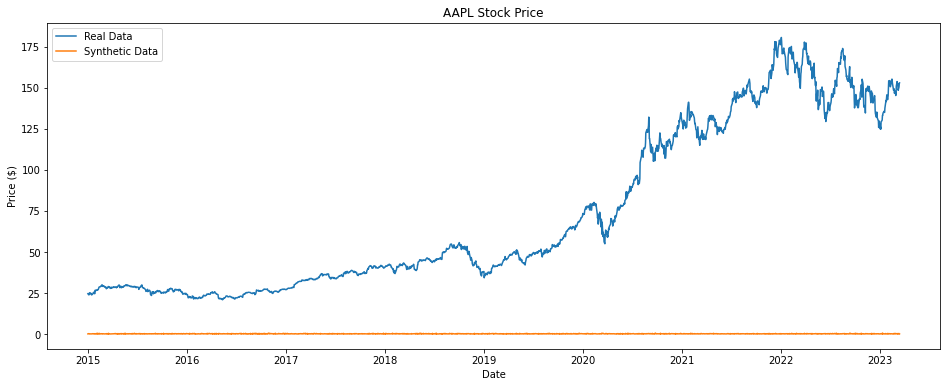

Epoch 100 D loss: 5.580118656158447 G loss: 2.5400197046110407e-05


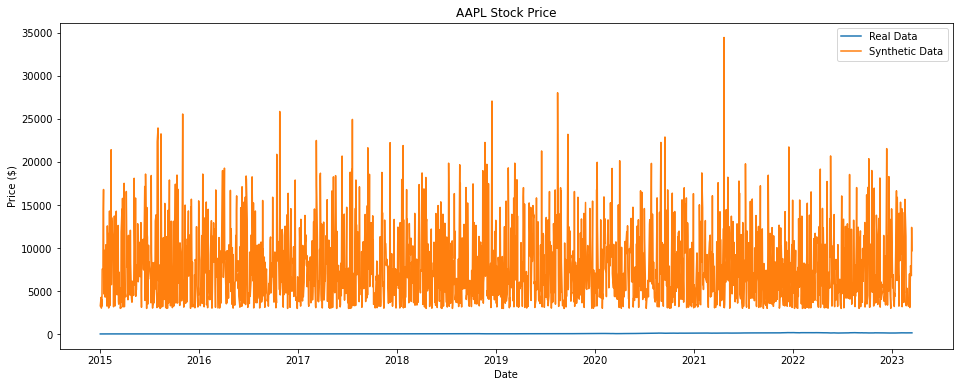

Epoch 200 D loss: 8.325542449951172 G loss: 1.7891085235532955e-07


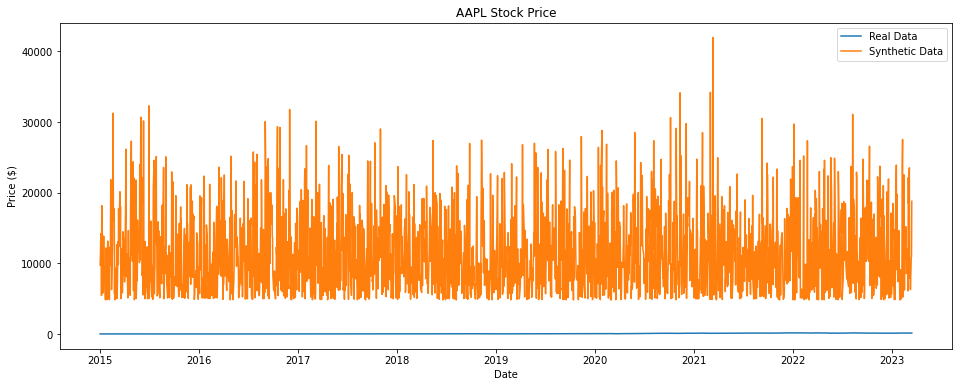

Epoch 300 D loss: 9.689001083374023 G loss: 7.59300888830694e-09


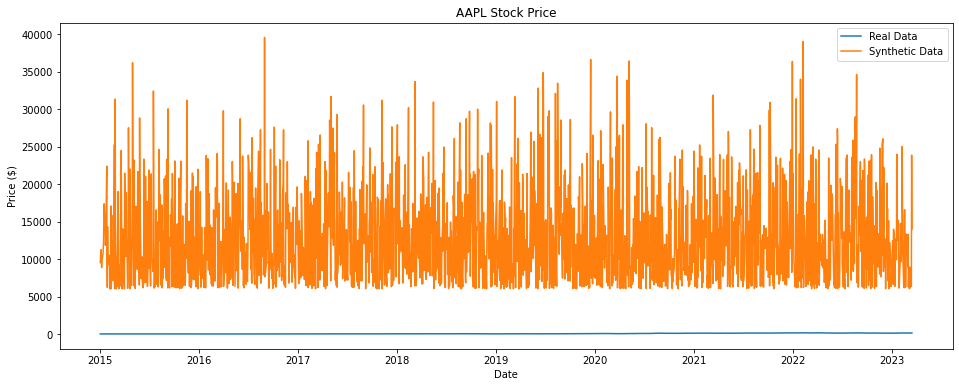

Epoch 400 D loss: 9.383110046386719 G loss: 2.0375066078770487e-09


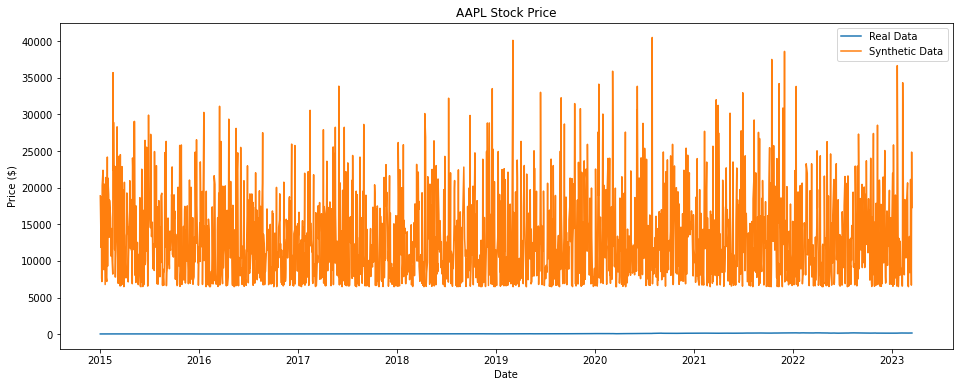

Real Data:
[ 24.56570053  23.87364388  23.87589073 ... 150.47000122 152.58999634
 152.99000549]

Synthetic Data:
[15178.647  16536.803  11478.237  ...  6990.4478  6869.1733  6706.358 ]


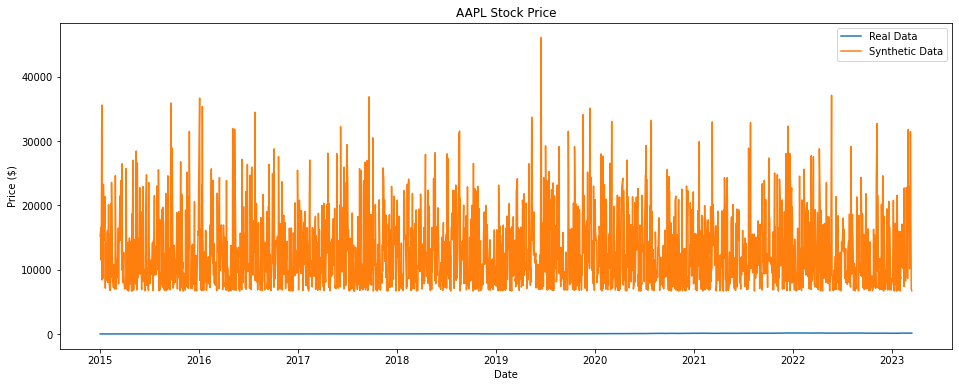

In [54]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=1, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1))
    model.summary()
    noise = Input(shape=(1,))
    gen_data = model(noise)
    return tf.keras.models.Model(noise, gen_data)

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    real_data = Input(shape=(1,))
    validity = model(real_data)
    return tf.keras.models.Model(real_data, validity)

def build_qgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = RMSprop(learning_rate=0.0002)
    model.compile(loss='mse', optimizer=optimizer)
    return model

generator = build_generator()
discriminator = build_discriminator()
qgan = build_qgan(generator, discriminator)

discriminator.compile(optimizer=RMSprop(learning_rate=0.0002), loss='binary_crossentropy')

num_epochs = 500
batch_size = 128

for epoch in range(num_epochs):
    noise = np.random.normal(0, 1, (batch_size, 1))
    gen_data = generator.predict(noise)
    real_data = stock_data["Adj Close"].values.reshape((-1, 1))[np.random.randint(0, len(stock_data), batch_size)]
    X = np.concatenate((real_data, gen_data))
    y = np.zeros((2*batch_size, 1))
    y[:batch_size, :] = 1
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)
    noise = np.random.normal(0, 1, (batch_size, 1))
    y = np.ones((batch_size, 1))
    discriminator.trainable = False
    g_loss = qgan.train_on_batch(noise, y)
    if epoch % 100 == 0:
        print("Epoch", epoch, "D loss:", d_loss, "G loss:", g_loss)
        
        num_samples = len(stock_data)
        noise = np.random.normal(0, 1, (num_samples, 1))
        gen_data = generator.predict(noise)
        gen_data = np.squeeze(gen_data)

        plt.figure(figsize=(16, 6))
        plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
        plt.plot(stock_data.index, gen_data, label="Synthetic Data")
        plt.legend()
        plt.title(f"{ticker} Stock Price")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.show()

num_samples = len(stock_data)
noise = np.random.normal(0, 1, (num_samples, 1))
gen_data = generator.predict(noise)
gen_data = np.squeeze(gen_data)

print("Real Data:")
print(stock_data["Adj Close"].values)

print("\nSynthetic Data:")
print(gen_data)

plt.figure(figsize=(16, 6))
plt.plot(stock_data.index, stock_data["Adj Close"], label="Real Data")
plt.plot(stock_data.index, gen_data, label="Synthetic Data")
plt.legend()
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

In [56]:
from tabulate import tabulate

real_data_df = pd.DataFrame(data=stock_data["Adj Close"].values.reshape((-1, 1)), columns=["Real Data"])
print("Real Data Table:")
print(tabulate(real_data_df, headers='keys', tablefmt='psql'))

gen_data_df = pd.DataFrame(data=gen_data, columns=["Synthetic Data"])
print("\nSynthetic Data Table:")
print(tabulate(gen_data_df, headers='keys', tablefmt='psql'))


Real Data Table:
+------+-------------+
|      |   Real Data |
|------+-------------|
|    0 |     24.5657 |
|    1 |     23.8736 |
|    2 |     23.8759 |
|    3 |     24.2107 |
|    4 |     25.1409 |
|    5 |     25.1679 |
|    6 |     24.5477 |
|    7 |     24.7657 |
|    8 |     24.6713 |
|    9 |     24.0017 |
|   10 |     23.8152 |
|   11 |     24.4286 |
|   12 |     24.6151 |
|   13 |     25.2555 |
|   14 |     25.3858 |
|   15 |     25.4128 |
|   16 |     24.523  |
|   17 |     25.9094 |
|   18 |     26.716  |
|   19 |     26.325  |
|   20 |     26.6553 |
|   21 |     26.6598 |
|   22 |     26.8643 |
|   23 |     27.0561 |
|   24 |     26.8282 |
|   25 |     27.0064 |
|   26 |     27.5253 |
|   27 |     28.1704 |
|   28 |     28.5268 |
|   29 |     28.6667 |
|   30 |     28.8359 |
|   31 |     29.0366 |
|   32 |     28.9757 |
|   33 |     29.2126 |
|   34 |     30.0021 |
|   35 |     29.8149 |
|   36 |     29.0524 |
|   37 |     29.4201 |
|   38 |     28.978  |
|   39 |     29.1